In [1]:
import matplotlib.pyplot as plt
import json


In [2]:
import json

def get_power_estimation(voltage_file, power_file, unit='W'):
    R_shunt = 0.1 # ohms
    # V_dd = 1e6 # micro-volts
    V_dd = 0.997e6 # micro-volts
    
    if unit == 'W':
        scalar = 1e-6
    elif unit == 'mW':
        scalar = 1e-3
    elif unit == 'uW':
        scalar = 1

    volt_dict = {}
    power_dict = {}

    with open(voltage_file, 'r') as volt:
        volt_dict = json.load(volt)
        volt.close()

    
    for benchmark, voltage_avg in volt_dict['voltage'].items():
        power_dict[benchmark] = scalar*(V_dd - voltage_avg)*scalar*voltage_avg/R_shunt # multiplied by scalar twice to convert both voltage and current

    with open(power_file, 'w') as pow:
        json.dump(power_dict, pow)
        pow.close()

    return power_dict
        
def get_energy_estimation(time_file, power_file, energy_file, unit='mJ', cpu_freq=20e6):
    time_dict = {}        
    power_dict = {} # power must be in W.         
    energy_dict = {}   

    if unit == "uJ":
        t_cycle = 1e6/cpu_freq
    elif unit == "J":
        t_cycle = 1/cpu_freq
    elif unit == "mJ":
        t_cycle = 1e3/cpu_freq
    elif unit == "nJ":
        t_cycle = 1e9/cpu_freq


    with open(time_file, 'r') as time:
        time_dict = json.load(time)['cycles']
        time.close()

    with open(power_file, 'r') as power:
        power_dict = json.load(power)
        power.close()
    
    for bm, p in power_dict.items():
        energy_dict[bm] = p*time_dict[bm]*t_cycle
    
    with open(energy_file, 'w') as en:
        json.dump(energy_dict, en)
        en.close()

    return energy_dict

### Total Core Power (static + dynamic)

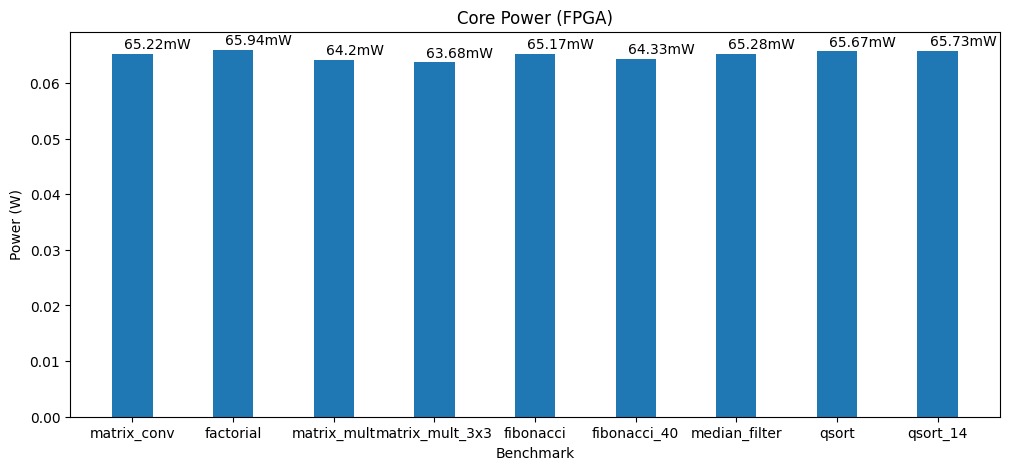

In [3]:
unit = 'W'

power_estimation = get_power_estimation("energy_files/estimation_voltage_benchmark.json", "energy_files/estimation_power_benchmark.json", unit= unit)

plt.figure(figsize=(12, 5))
plt.title(f"Core Power (FPGA)")
plt.bar(power_estimation.keys(), power_estimation.values(), width=0.4, align= 'center')
for i, v in enumerate(power_estimation.values()):
    plt.text(i-0.08, v+0.001, str(round(v*1e3, 2))+"mW")
plt.xlabel("Benchmark")
plt.ylabel(f"Power ({unit})")
plt.show()

### Static Core Power

In [5]:
# According to the measurements the static core power is around 38 mW
static_core_power = 0.038  

### Dynamic Core Power

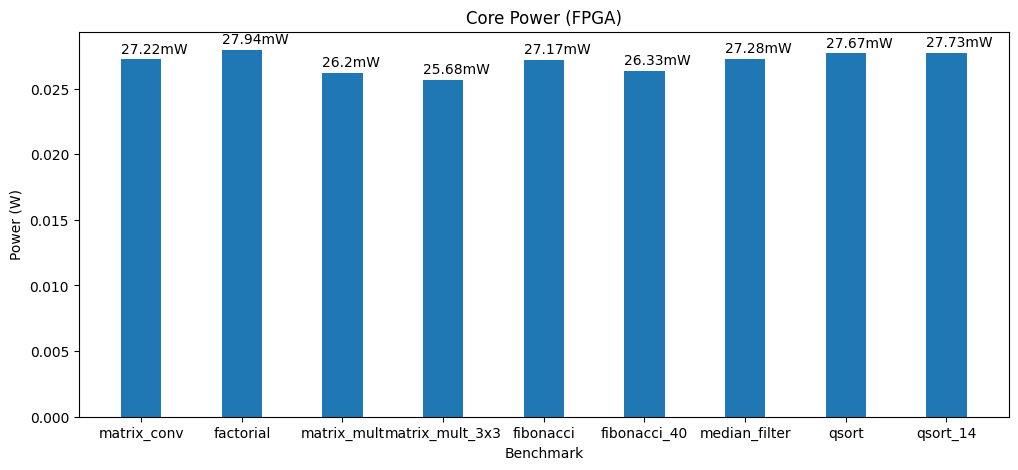

In [15]:
# Subtract the static power from the total power to obtain the dynamic power

unit = 'W'

power_estimation = get_power_estimation("energy_files/estimation_voltage_benchmark.json", "energy_files/estimation_power_benchmark.json", unit= unit)

power_estimation_val = [d-static_core_power for d in power_estimation.values()]

plt.figure(figsize=(12, 5))
plt.title(f"Core Power (FPGA)")
plt.bar(power_estimation.keys(), power_estimation_val, width=0.4, align= 'center')
for i, v in enumerate(power_estimation_val):
    plt.text(i-0.2, v+0.0005, str(round(v*1e3, 2))+"mW")
plt.xlabel("Benchmark")
plt.ylabel(f"Power ({unit})")
plt.show()

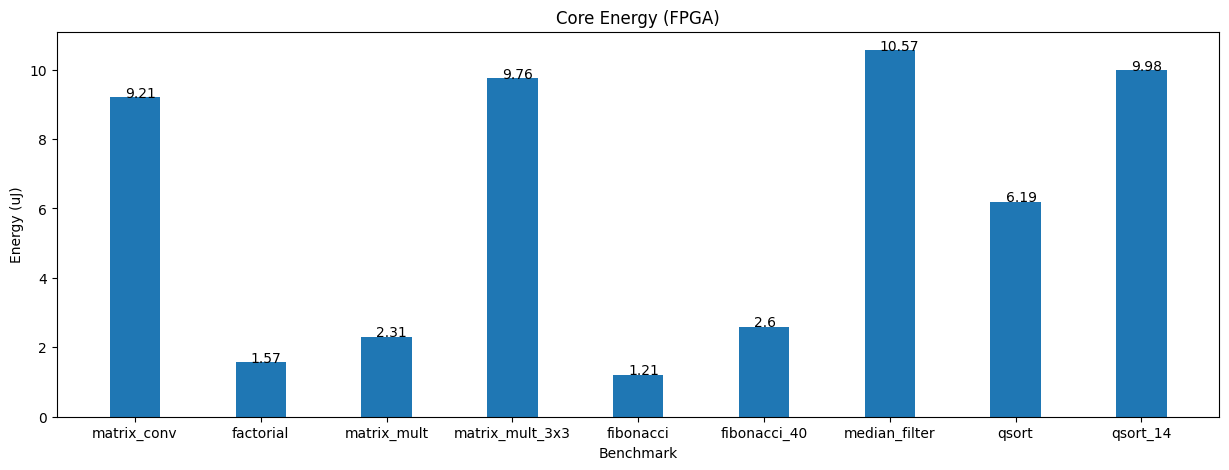

In [38]:
unit = 'uJ'

energy_estimation = get_energy_estimation(
    time_file= "energy_files/estimation_voltage_benchmark.json",
    power_file= "energy_files/estimation_power_benchmark.json", 
    energy_file= "energy_files/estimation_energy_benchmark.json", unit=unit)

plt.figure(figsize=(15, 5))
plt.title(f"Core Energy (FPGA)")
plt.bar(energy_estimation.keys(), energy_estimation.values(), width=0.4, align= 'center')
for i, v in enumerate(energy_estimation.values()):
    plt.text(i-0.08, v, str(round(v, 2))+"")
plt.xlabel("Benchmark")
plt.ylabel(f"Energy ({unit})")
plt.show()

In [3]:
I = 0.067
1*I-0.1*(I**2)

0.0665511

In [20]:
def P_core(V):
    V_dd= 0.997 # 1
    R_shunt = 0.1
    return (V_dd - V)*V/R_shunt

In [22]:
from statistics import mean

V_core = [0.99045, 0.99057, 0.99036, 0.99027, 0.99029, 0.99048, 0.99052, 0.99034, 0.99025, 0.9903]
V_shunt = [0.0065601, 0.0064263, 0.0066182, 0.0065283, 0.0065381, 0.0065935, 0.0065457, 0.006687, 0.0066761, 0.0066925]

P_v_core = [P_core(c) for c in V_core]
P_v_shunt = [P_core(s) for s in V_shunt]

avg_P_v_core = mean(P_v_core)
avg_P_v_shunt = mean(P_v_shunt)

print("avg core P(v_core)", avg_P_v_core, "W", f'({avg_P_v_core*1e3} mW)')
print("avg core P(v_shunt)", avg_P_v_shunt, "W", f'({avg_P_v_shunt*1e3} mW)')
print("abs_error", abs(avg_P_v_shunt - avg_P_v_core), "W")
print("rel_error", 100*abs(avg_P_v_shunt - avg_P_v_core)/avg_P_v_core, "%")

avg core P(v_core) 0.06553352710000006 W (65.53352710000006 mW)
avg core P(v_shunt) 0.06523430806536 W (65.23430806536 mW)
abs_error 0.00029921903464005806 W
rel_error 0.4565892419974108 %


In [19]:
avg_v_core = mean(V_core)
avg_v_shunt = mean(V_shunt)
print("avg_v_core", avg_v_core, "V")
print("avg_v_shunt", avg_v_shunt, "V")
print("SUM", avg_v_shunt + avg_v_core)

avg_v_core 0.990383 V
avg_v_shunt 0.00658658 V
SUM 0.99696958


In [29]:
print("static V_shunt", P_core(0.0040166))
print("static V_core", P_core(0.994))

static V_shunt 0.039884171244399996
static V_core 0.029820000000000024
